In [1]:
import re
from sympy.parsing.latex import parse_latex
from sympy import Basic
import sympy
import numpy as np
from pprint import pprint
from transformers import AutoTokenizer
import random
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K")

In [ ]:
train_ds = ds['train'][:10000]

In [ ]:

NUM_SAMPLES = 1000
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES)

In [ ]:
train_ds_qs = train_ds['question']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']

# Preliminary tasks

## Briefly describe the data

In [ ]:
# TODO

## Parsing

### Notes
- [x] Questions have different latex sytanx (`[`, `(`, `$`)
- [] How do we tokenize the latex formula?
  - [x] `hybrid_tokenize` with word lenght tokens
  - [x] pretrained tokenizers from hf
  - [] https://github.com/google/sentencepiece

In [ ]:
train_ds_qs = np.array(train_ds_qs)
train_ds_qs = train_ds_qs[random_indices]

reason_1_ds = np.array(reason_1_ds)
reason_1_ds = reason_1_ds[random_indices]

reason_2_ds = np.array(reason_2_ds)
reason_2_ds = reason_2_ds[random_indices]

reason_3_ds = np.array(reason_3_ds)
reason_3_ds = reason_3_ds[random_indices]

### Initial investigation on sympy

In [ ]:

def extract_latex_bracket_content(text):
    patterns = [
        r'\\\[(.*?)\\\]',  # \[ ... \]
        r'\\\((.*?)\\\)',  # \( ... \)
        r'\$(.*?)\$',       # $ ... $
    ]
    # Combine patterns into one
    combined_pattern = '|'.join(patterns)
    #matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    #formulas = [next(filter(None, tup)) for tup in matches]
    matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    formulas = []
    for tup in matches:
        non_empty = list(filter(None, tup))
        if non_empty:
            formulas.append(non_empty[0])
    # Use a counter to number the placeholders
    def replacer(match, counter=[1]):
        placeholder = "{" + str(counter[0]-1) + "}"
        counter[0] += 1
        return placeholder
    new_text = re.sub(combined_pattern, replacer, text)
    return new_text, formulas

parsed_indices = []
parsed_text = []
parsed_formulas = []
for i in range(len(train_ds_qs)):
    d = train_ds_qs[i]
    #print("original input:", d)
    text, formulas = extract_latex_bracket_content(d)
    #print("parsed text: ", text, "\nequations: ", formulas)
    formulas_sympy = []
    num_parsed = 0
    for expr in formulas:
        try:
            parsed = parse_latex(expr)
            formulas_sympy.append(parsed)
            num_parsed += 1
        except Exception as e:
            pass
            #print("Could not parse:", e)
            #print(parsed)
    if num_parsed == len(formulas):
        parsed_indices.append(i)
        parsed_text.append(text)
        parsed_formulas.append(formulas_sympy)
print("correctly parsed", len(parsed_indices), "inputs over", len(train_ds_qs))

### Hybrid tokenizer

In [ ]:
def print_sympy_tree(expr, indent=0):
    print('  ' * indent + str(expr.func))
    for arg in expr.args:
        print_sympy_tree(arg, indent + 1)

# --- Parse LaTeX into sympy then walk the expression tree ---
def flatten_sympy_expr(expr: Basic):
    tokens = []

    def walk(node):
        if isinstance(node, Basic):
            args_len = len(node.args)
            args = node.args
            # If only 1 we build the output as operator + walk(operand)
            if args_len == 1:
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                walk(args[0])
            # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
            elif args_len == 2:
                walk(args[0])
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                walk(args[1])
            # If no operands are found we just add self
            elif args_len == 0:
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
            # If there are multiple operands (> 2) we add them all after the operator
            else:
                if isinstance(node, (sympy.Limit, sympy.Integral)):
                    args = reversed(args)
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                for arg in args:
                    walk(arg)
        else:
            raise RuntimeError("not sympy Basic object")

    walk(expr)
    return tokens

# --- Main tokenization function ---
def hybrid_tokenize(text):
    math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
    parts = re.split(math_pattern, text, flags=re.DOTALL)

    final_tokens = []
    is_erorr = False
    for part in parts:
        if re.match(math_pattern, part, flags=re.DOTALL):
            # Clean math delimiters
            clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
            try:
                parsed = parse_latex(clean)
                math_tokens = flatten_sympy_expr(parsed)
                final_tokens.extend(math_tokens)
            except Exception as e:
                is_erorr = True
                final_tokens.extend(clean.split(' '))
        else:
            final_tokens.extend(re.findall(r'\b\w+\b', part))
    return is_erorr, final_tokens



In [ ]:

parsed_inputs = []
not_parsed_inputs = []
for d in train_ds_qs:
    error, tokens = hybrid_tokenize(d)
    if not error:
        parsed_inputs.append(tokens)
    else:
        not_parsed_inputs.append(tokens)


print("correctly parsed", len(parsed_inputs), "inputs over", len(train_ds_qs))
print("not parsed", len(not_parsed_inputs), "inputs over", len(train_ds_qs))


In [ ]:
not_parsed_inputs[:1]

### Tokenization with different pretrained

In order to fit all the qs and reasonings we need a large context window tokenizer. We found that 4k of longformer is enough (for random 1000 samples).

In [ ]:
model_name = "allenai/longformer-base-4096"
#model_name = "lmsys/longchat-13b-16k"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
token_ids = []
tokens = []
for d in train_ds_qs:
	#tokens = tokenizer.tokenize(d)
    tokens.append(tokenizer.tokenize(d))
    token_ids.append(tokenizer.encode(d))

In [ ]:
r1_tokens_id = []
r1_tokens = []
for d in reason_1_ds:
	#tokens = tokenizer.tokenize(d)
    r1_tokens.append(tokenizer.tokenize(d))
    r1_tokens_id.append(tokenizer.encode(d))

In [ ]:
r2_tokens_id = []
r2_tokens = []
for d in reason_2_ds:
	#tokens = tokenizer.tokenize(d)
    r2_tokens.append(tokenizer.tokenize(d))
    r2_tokens_id.append(tokenizer.encode(d))

In [ ]:
r3_tokens_id = []
r3_tokens = []
for d in reason_3_ds:
	#tokens = tokenizer.tokenize(d)
    r3_tokens.append(tokenizer.tokenize(d))
    r3_tokens_id.append(tokenizer.encode(d))

In [ ]:
for i in range(3):
    print(tokens[i])
    print(token_ids[i])
    print(len(token_ids[i]))
    print(len(tokens[i]))


## Perform cluster analysis on questions field

## Perform cluster analysis on questions field

In [ ]:
# TODO

## Perform document index on different fields

In [ ]:
# pip install -q python-terrier==0.11.0 #now there is another version but we don't use it

In [ ]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@11/11.0.21/libexec/openjdk.jdk/Contents/Home"
os.environ["JVM_PATH"] = "/opt/homebrew/Cellar/openjdk@11/11.0.26/libexec/openjdk.jdk/Contents/Home/lib/server/libjvm.dylib"

In [ ]:
column_names = train_ds.column_names
print(column_names)

# 2. Initialize PyTerrier (only once)
import pyterrier as pt

# google colab
#if not pt.started():
#  pt.init()

# vs code in mac
if not pt.java.started():
    pt.init()

### Finding "quadratic form" in 'question'

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(train_ds),
    fields=('question',),
    meta=('docno', 'question')  # store docno + question in the metadata
)

# 5. Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results = tfidf.search("quadratic form")
print(results.head(6))

### Perform a 'question' search in only documents with x difficulty

In [ ]:
# Imposto difficulty = 0.0
filtered_ds = [ex for ex in train_ds if float(ex['difficulty']) == 0.0]

# Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(filtered_ds),
    fields=('question',),
    meta=('docno', 'question')
)

# Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
query = "quadratic form"
query1 = "quadratic form optimization minimize" #puoi mettere piu parole e funziona
results = tfidf.search(query)
print(results.head(6))

### Finding 'quadratic form' in more fields (NON RIUSCITO)

## Generate embeddings and analyze them

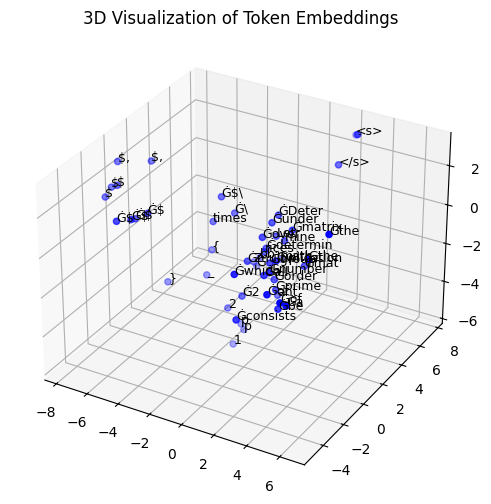

In [ ]:
# Example token IDs (replace with your token IDs)
token_id = token_ids[45]

model = AutoModel.from_pretrained(model_name)

# Convert token IDs to embeddings
input_ids = torch.tensor([token_id])  # Add batch dimension
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, hidden_dim)

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Visualize in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c='blue', marker='o')

# Annotate tokens
tokens = tokenizer.convert_ids_to_tokens(token_id)
for i, token in enumerate(tokens):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], token, fontsize=9)

ax.set_title("3D Visualization of Token Embeddings")
plt.show()

# Training

## M1C: Base model (topic classification)

In [ ]:
!pip install latex2sympy2-extended
import re
import logging
from functools import lru_cache
from typing import List, Tuple

import sympy as sp
from latex2sympy2_extended import latex2sympy

# -----------------------------------------------------------------------------
#  Regex & cleaning helpers
# -----------------------------------------------------------------------------
_MATH_ENV_RE = re.compile(
    r"\$\$(.*?)\$\$"                    # $$...$$
    r"|\\\[(.*?)\\\]"                   # \[...\]
    r"|\\\((.*?)\\\)"                   # \(...\)
    r"|\$(.*?)\$"                           # $...$
    r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
    re.DOTALL,
)

_CLEAN_REPLACES = [
    (r"\\displaystyle", ""),
    (r"\\left|\\right", ""),           # sizing commands
    (r"\\[ ,;!]", ""),                 # spacing commands
]

_WORD_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)


def clean_latex(latex: str) -> str:
    for pat, rep in _CLEAN_REPLACES:
        latex = re.sub(pat, rep, latex)
    return re.sub(r"\s+", " ", latex).strip()


def extract_math_spans(text: str) -> Tuple[str, List[str]]:
    spans: List[str] = []
    def _repl(m: re.Match) -> str:
        latex = next(g for g in m.groups() if g is not None)
        idx = len(spans)
        spans.append(latex)
        return f"[[MATH{idx}]]"
    return _MATH_ENV_RE.sub(_repl, text), spans


def flatten_sympy_expr(expr: sp.Basic) -> List[str]:
    if expr.is_Atom:
        return [str(expr)]
    toks = [expr.func.__name__]
    for arg in expr.args:
        toks.extend(flatten_sympy_expr(arg))
    return toks

# -----------------------------------------------------------------------------
#  LaTeX → tokens converter
# -----------------------------------------------------------------------------
@lru_cache(maxsize=200_000)
def tokenize_math(latex: str) -> Tuple[bool, List[str]]:
    latex = clean_latex(latex)
    if len(latex) > 500 or latex.count("{") > 25:
        return False, latex.split()

    try:
        expr = latex2sympy(latex, dummy_symbol_func=lambda n: sp.Symbol(n))
        return False, flatten_sympy_expr(expr)
    except Exception as exc:
        logging.debug("[tokenize_math] fallback on `%s` (%s)", latex, exc)
        # fallback but treat as no error
        return False, latex.split()

# -----------------------------------------------------------------------------
#  Plain-text and hybrid tokenizers
# -----------------------------------------------------------------------------

def text_tokenize(text: str) -> List[str]:
    return _WORD_RE.findall(text)


def hybrid_tokenizee(text: str) -> Tuple[bool, List[str]]:
    cleaned, spans = extract_math_spans(text)
    parts = re.split(r"(\[\[MATH\d+\]\])", cleaned)

    tokens: List[str] = []
    had_error = False

    for part in parts:
        m = re.fullmatch(r"\[\[MATH(\d+)\]\]", part)
        if m:
            idx = int(m.group(1))
            err, mtoks = tokenize_math(spans[idx])
            had_error |= err
            tokens.extend(mtoks)
            continue

        raw = text_tokenize(part)
        i = 0
        while i < len(raw):
            if raw[i].startswith("\\"):
                depth = raw[i].count("{") - raw[i].count("}")
                j = i + 1
                while j < len(raw) and depth > 0:
                    depth += raw[j].count("{") - raw[j].count("}")
                    j += 1
                latex_inline = " ".join(raw[i:j])
                err, mtoks = tokenize_math(latex_inline)
                had_error |= err
                tokens.extend(mtoks)
                i = j
            else:
                tokens.append(raw[i])
                i += 1

    return had_error, tokens

initial investigation on which classification method works better for this dataset

fitted: LinearSVC(max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000)
fitted: LogisticRegression(max_iter=1000, n_jobs=-1)
fitted: MultinomialNB()


,model,accuracy,macro_f1
0,LinearSVC,0.637087,0.433079
1,SGD-hinge,0.515614,0.357035
3,LogisticRegression,0.617108,0.351514
2,SGD-log,0.489380,0.344245
4,MultinomialNB,0.431772,0.127509


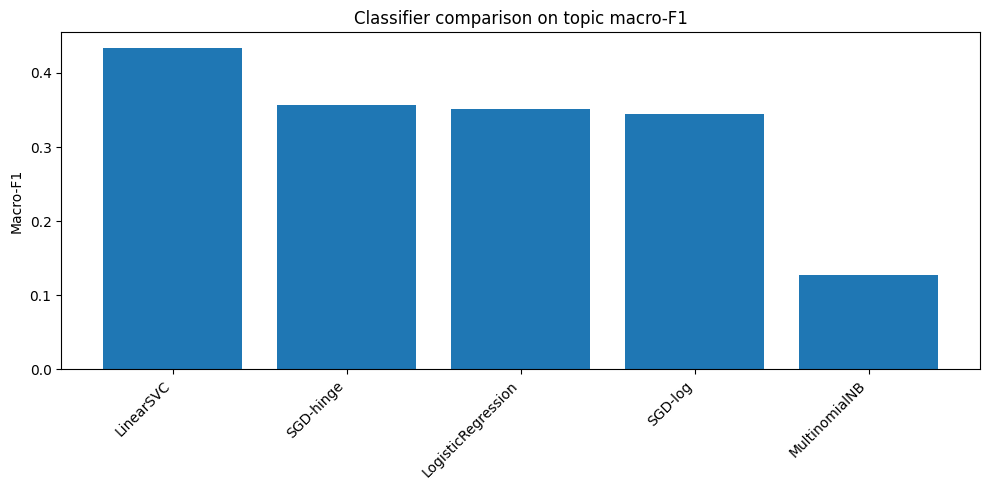

In [7]:
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

train_ds=ds['train']
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    train_ds["question"], train_ds["topic"],
    test_size=0.2, random_state=42, stratify=train_ds["topic"]
)

# 2. Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)
from collections import Counter
counts = Counter(y_train)
total = len(y_train)

# Inverse‐frequency weights
weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}
# 3. Tokenizer wrapper (uses your hybrid_tokenizee)
#from hybrid_math_text_parser import hybrid_tokenizee
def my_tokenizer(txt):
    return hybrid_tokenizee(txt)[1]

# 4. Define a suite of classifiers to compare
classifiers = {
    "LinearSVC":             LinearSVC(max_iter=10000),
    "SGD-hinge":             SGDClassifier(loss="hinge", class_weight="balanced", max_iter=10000),
    "SGD-log":               SGDClassifier(loss="log_loss",  class_weight="balanced", max_iter=10000),
    "LogisticRegression":    LogisticRegression(max_iter=1000, n_jobs=-1),
    "MultinomialNB":         MultinomialNB(),
}

# 5. Train, predict, record metrics
results = []
for name, clf in classifiers.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer=my_tokenizer,
            lowercase=True,
            token_pattern=None
        )),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    print("fitted:",clf)
    yp = pipe.predict(X_test)
    results.append({
        "model":    name,
        "accuracy": accuracy_score(y_test, yp),
        "macro_f1": f1_score(y_test, yp, average="macro")
    })

df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(df)

# 6. Plot macro-F1 for easy comparison
plt.figure(figsize=(10,5))
plt.bar(df["model"], df["macro_f1"])
plt.ylabel("Macro-F1")
plt.xticks(rotation=45, ha="right")
plt.title("Classifier comparison on topic macro-F1")
plt.tight_layout()
plt.show()


turns out LinearSVC is the best, let's tune it with optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, f1_score

X       = train_ds["question"]
y_raw   = train_ds["topic"]
le      = LabelEncoder()
y       = le.fit_transform(y_raw)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


from collections import Counter
counts = Counter(y_train)
total  = len(y_train)
n_cls  = len(counts)
weights = {
    cls : total/(n_cls * count)
    for cls, count in counts.items()
}


def tokenizer(txt):
    return hybrid_tokenizee(txt)[1]


def objective(trial):
    # TF–IDF params
    ngram_min    = trial.suggest_int("ngram_min", 1, 2)
    ngram_max    = trial.suggest_int("ngram_max", ngram_min, 3)
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    #max_features = int(trial.suggest_int("max_features", 10_000, 50_000, step=5_000))

    # LinearSVC params
    C            = trial.suggest_float("C", 1e-4, 1e2, log=True)
    weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
    if weight_choice == "none":
        class_weight = None
    else:
        class_weight = weights
    loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    dual         = True if loss == "hinge" else False

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
             tokenizer=tokenizer,
             lowercase=True,
             token_pattern=None,
             ngram_range=(ngram_min, ngram_max),
             max_df=max_df,
             min_df=min_df,
             #max_features=max_features,
        )),
        ("clf", LinearSVC(
             C=C,
             class_weight=class_weight,
             loss=loss,
             dual=dual,
             max_iter=1000,
             random_state=42
        ))
    ])

    
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score, average="macro")

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring=scorer, n_jobs=1
    )
    return scores.mean()



study = optuna.create_study(direction="maximize", study_name="LinearSVC_tuning")
study.optimize(objective, n_trials=50, timeout=3600)


print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-05-06 09:46:10,725] A new study created in memory with name: LinearSVC_tuning
[I 2025-05-06 09:48:30,617] Trial 0 finished with value: 0.2508989676894493 and parameters: {'ngram_min': 2, 'ngram_max': 3, 'max_df': 0.7434359565132712, 'min_df': 4, 'C': 0.0002871545361444367, 'weight_choice': 'custom', 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.2508989676894493.
[I 2025-05-06 09:50:01,989] Trial 1 finished with value: 0.3602970669467035 and parameters: {'ngram_min': 2, 'ngram_max': 2, 'max_df': 0.9637278903047333, 'min_df': 1, 'C': 0.39315203742127985, 'weight_choice': 'none', 'loss': 'hinge'}. Best is trial 1 with value: 0.3602970669467035.
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.

Best macro-F1: 0.4080447920063257
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.652179599157025, 'min_df': 1, 'C': 1.679602370511424, 'weight_choice': 'none', 'loss': 'hinge'}


lets fit the model

In [ ]:
#from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


X = train_ds["question"]
y_raw = train_ds["topic"]


le = LabelEncoder()
y = le.fit_transform(y_raw)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=lambda txt: hybrid_tokenizee(txt)[1],
        lowercase=True,
        token_pattern=None, ngram_range=(1,2),max_df=0.652179599157025,min_df=1
    )),
    ("clf", LinearSVC(max_iter=10000,C=1.679602370511424, class_weight=None,loss='hinge'))
])


pipe.fit(X_train, y_train)


y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6472699059257104

Classification report:

                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.40      0.40      0.40         5
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.73      0.65      0.69       555
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.85      0.89      0.87       774
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.88      0.88      0.88         8
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.50      0.45      0.47       303
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## M1R: Base model (difficulty regression)

## M1S: Base model (short answer)

## M2: Introduce reasoning

## Comparisons